In [1]:
import os

In [2]:
os.sys.path

['',
 '/home/cfcv/miniconda3/envs/gym-duckietown/lib/python36.zip',
 '/home/cfcv/miniconda3/envs/gym-duckietown/lib/python3.6',
 '/home/cfcv/miniconda3/envs/gym-duckietown/lib/python3.6/lib-dynload',
 '/home/cfcv/miniconda3/envs/gym-duckietown/lib/python3.6/site-packages',
 '/home/cfcv/miniconda3/envs/gym-duckietown/lib/python3.6/site-packages/IPython/extensions',
 '/home/cfcv/.ipython']

In [3]:
os.sys.path.append("../gym-duckietown")

In [4]:
os.sys.path

['',
 '/home/cfcv/miniconda3/envs/gym-duckietown/lib/python36.zip',
 '/home/cfcv/miniconda3/envs/gym-duckietown/lib/python3.6',
 '/home/cfcv/miniconda3/envs/gym-duckietown/lib/python3.6/lib-dynload',
 '/home/cfcv/miniconda3/envs/gym-duckietown/lib/python3.6/site-packages',
 '/home/cfcv/miniconda3/envs/gym-duckietown/lib/python3.6/site-packages/IPython/extensions',
 '/home/cfcv/.ipython',
 '../gym-duckietown']

In [5]:
import numpy as np
import gym
import gym_duckietown
from gym_duckietown.envs.duckietown_env import * #DuckietownEnv

In [6]:
map_name='udem1',
max_steps=1500,
draw_curve=False,
draw_bbox=False,
domain_rand=False,
frame_rate=30,
frame_skip=1,
camera_width=640,
camera_height=480,
robot_speed=1.20, #MAXIMUM FORWARD ROBOT SPEED
accept_start_angle_deg=60,
full_transparency=False,
user_tile_start=None,
seed=None,
distortion=False,
randomize_maps_on_reset=False,

In [6]:
env = DuckietownLF(map_name='straight_road',
max_steps=1500,
draw_curve=False,
draw_bbox=False,
domain_rand=False,
frame_rate=30,
frame_skip=1,
camera_width=640,
camera_height=480,
robot_speed=1.20, #MAXIMUM FORWARD ROBOT SPEED
accept_start_angle_deg=1,
full_transparency=False,
user_tile_start=None,
seed=None,
distortion=False,
randomize_maps_on_reset=False,)

/home/cfcv/miniconda3/envs/gym-duckietown/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
env.reset()
env.render()

count = 0
while(count < 300):
    action = np.array([0.0, 0.0])
    obs, reward, done, info = env.step(action)
    count += 1
    env.render()
    
env.close()

In [8]:
obs.shape

(480, 640, 3)

In [49]:
import matplotlib.pyplot as plt
import cv2
from scipy import stats

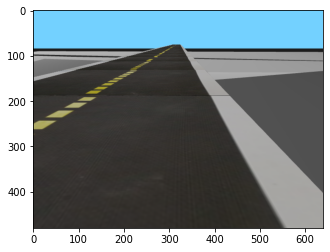

In [10]:
plt.imshow(obs)

In [11]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [12]:
gray = grayscale(obs)

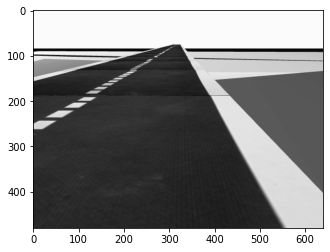

In [13]:
plt.imshow(gray, cmap='gray')

In [14]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [16]:
blured = gaussian_blur(gray, 5)

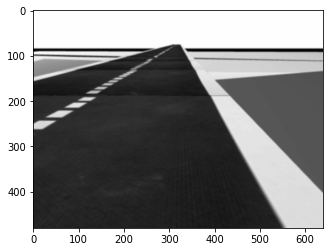

In [18]:
plt.imshow(blured, cmap='gray')

In [19]:
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

In [21]:
img_canny = canny(blured, 50, 150)

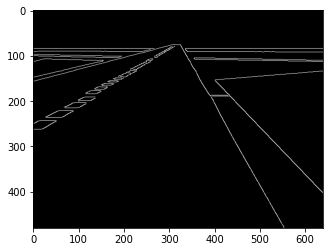

In [23]:
plt.imshow(img_canny, cmap='gray')

In [33]:
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [111]:
mask = region_of_interest(img_canny, np.array([[(0,200), (640,200), (640,480), (0,480)]]))

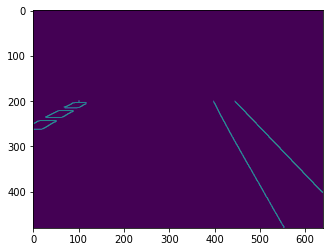

In [112]:
plt.imshow(mask)

In [36]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [37]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

In [113]:
line_image, lines = hough_lines(mask, 1, np.pi/180, 10, 10, 10)

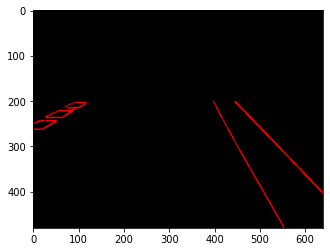

In [114]:
plt.imshow(line_image)

In [102]:
def triage_lines(image, lines):
    separed_lines = np.zeros_like(image)
    
    left= []
    right = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            dy = y2 - y1
            dx = x2 - x1
            
            if(dy == 0 or dx == 0):
                continue
            
            A = dy/dx
            if(abs(A) < 0.1):
                continue

            if(A < 0):
                left.append(line)
                cv2.line(separed_lines, (x1, y1), (x2, y2), [255,0,0], 2)
            else:
                right.append(line)
                cv2.line(separed_lines, (x1, y1), (x2, y2), [255,255,0], 2)
    
    return left, right, separed_lines

In [115]:
left_lines, right_lines, separed_lines_image = triage_lines(line_image, lines)

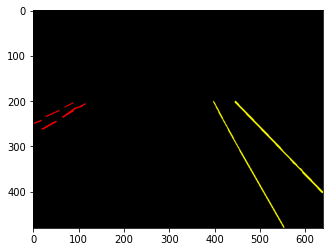

In [116]:
plt.imshow(separed_lines_image)

In [179]:
def average_lines(left_lines, right_lines, image):
    line_image = np.zeros_like(image)
    
    #Apply linear regression to all the points of the left lines
    pts_x = []
    pts_y = []
    
    for line in left_lines:
        for x1,y1,x2,y2 in line:
            pts_x.append(x1)
            pts_x.append(x2)
            pts_y.append(y1)
            pts_y.append(y2)
    #Find the line(y = Ax + B) that best fit the points    
    left_A, left_B, _, _, _ = stats.linregress(pts_x, pts_y)
    
    #Apply liner regression to all the points of the right lines 
    pts_x = []
    pts_y = []
    
    for line in right_lines:
        for x1,y1,x2,y2 in line:
            pts_x.append(x1)
            pts_x.append(x2)
            pts_y.append(y1)
            pts_y.append(y2)
    #Find the line(y = Ax + B) that best fit the points    
    right_A, right_B, _, _, _ = stats.linregress(pts_x, pts_y)
    right_A += 0.3
    right_B -= 150
    height = image.shape[0]
    
    #if y = Ax + B then x = (y - B) / A
    left_line_p1 = (int((height-1 - left_B)/left_A), height-1)
    left_line_p2 = (int((200 - left_B)/left_A), 200)
    
    right_line_p1 = (int((height-1 - right_B)/right_A), height-1)
    right_line_p2 = (int((200 - right_B)/right_A), 200)
    
    cv2.line(line_image, left_line_p1, left_line_p2, [255,0,0], 10)
    cv2.line(line_image, right_line_p1, right_line_p2, [255,255,0], 10)
    
    return line_image

In [180]:
final_line_image = average_lines(left_lines, right_lines, separed_lines_image)

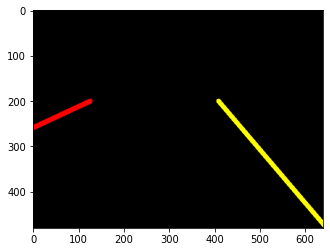

In [181]:
plt.imshow(final_line_image)

In [58]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [182]:
final = weighted_img(final_line_image, obs)

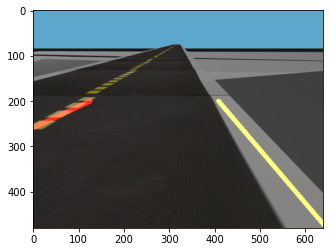

In [183]:
plt.imshow(final)

In [84]:
right_lines

[array([[401, 155, 639, 401]], dtype=int32),
 array([[431, 264, 554, 477]], dtype=int32),
 array([[473, 339, 553, 479]], dtype=int32),
 array([[494, 252, 636, 399]], dtype=int32),
 array([[383, 176, 498, 382]], dtype=int32)]

In [20]:
info

{'Simulator': {'action': [0.5823433496389471, 0.5823433496389471],
  'msg': 'Stopping the simulator because we are at an invalid pose.'},
 'DuckietownEnv': {'k': 27.0,
  'gain': 1.0,
  'train': 0.0,
  'radius': 0.0318,
  'omega_r': 15.723270440251572,
  'omega_l': 15.723270440251572}}